# Deep Learning Workshop 2

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" # set cuBLAS

import torch
import random
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path

from typing import *
from torch import Tensor
from PIL import Image

# seed training for deterministic results
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms(mode=True)

# seeded generator
g = torch.Generator()
g.manual_seed(0)

In [2]:
# !pip install torchvision

## Previously On...

During our previous workshop we saw how a multi-layer perceptron (MLP) with a ReLU non-linear activation function allowed us to learn to approximate arbitrary functions. We saw how building a deeper network with more neurons let us learn more complex and non-linear, and thus produce a more complex decision boundary.

<img src="ReLUPiecewise.png" alt="ReLU" height="500"/>

We used this idea to build an MLP model to classify the arms in a spiral dataset. Our model used two inputs $P=(x_{1}, x_{2})$ and produced one output $z$ which we used to classify whether the point belonged to spiral A or B. We used $z=0$ to classify a point as belonging to spiral A and $z=0$ to classify a point as belonging to spiral B.

<img src="SpiralClassification.png" alt="Spirals" height="500"/>

Within this workshop we will apply this same idea to performing image classification of digits using the MNIST dataset. We will begin with the same idea, the we can use an MLP to learn the mapping from the pixels in the image to the classified digit.

<img src="MNISTDataset.png" alt="MNIST" height="300"/>

We will explore the limitations of this approach, come up with some ideas as to how we can address these issues, and build a much more performant and flexible model architecture to perform this task using convolutional neural networks.

<img src="CNNMnist.png" alt="CNN" height="300"/>

We will then see how we can apply this same idea to lots of different application areas in both computer vision and pattern recognition more generally.

## [Section 1] Modelling MNIST using an MLP

Let's begin by seeing how we can use the ideas from the last workshop to classify images, for this we will be using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset contains a set of 70,000 images (split into 60,000 for training and 10,000 for testing) of digits and their associated labels.

Each grayscale image consists of 28x28 pixels, this means we have 784 pixels $(x_{1}, ..., x_{784})$ aranged in a grid. Each label is a number which ranges from $(0-9)$.

### The MNIST Dataset

As with before we will begin by loading in the dataset using `torchvision` and look at a few examples.

In [120]:
""" Download the MNIST dataset.
"""
# Download the dataset
from torchvision.datasets.mnist import MNIST
mnist = MNIST(root=Path(".").absolute(), train=False, download=True)

# Print some information about the dataset
print(mnist)

Dataset MNIST
    Number of datapoints: 10000
    Root location: /nas/home/can134/work/nggp-deeplearning-workshop2
    Split: Test


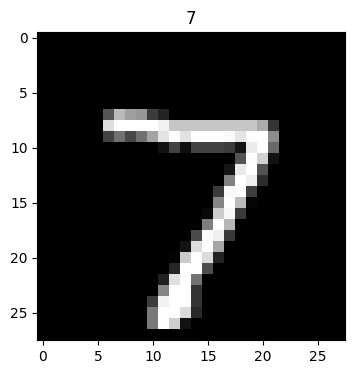

In [121]:
""" Have a look at some different examples of the images and their labels.
"""
# Define a function for plotting the sample
def plot_sample(img: Image, label: int):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{lbl}")
    return fig, ax

# Extract an item
img, lbl = mnist[0] # TODO: Experiment with different numbers here

# Plot the sample
_ = plot_sample(img, lbl)

### Building an MLP

Following our work from the previous workshop, we will use an MLP to learn the function that maps the 784 input pixels to the predicted digit in that image. We will use the MLP from the previous workshop with an input dimension of 784 and an output dimension of 10, where each output corresponds to the probably of the image being the associated digit. This is the same idea as before, however now we are learning a slightly more complex function with more input and output dimensions.

We first will create a `torch.utils.dataset.Dataset` which we can use to prepare the data for the model, we will use this to flatten the image from a 2-D set of 28x28 pixels into a 1-D set of 784 pixels. We need to flatten the image in order to be able to provide it to our MLP, as we have no way to encode the pixel structure.

<img src="Flatten.png" alt="Flatten" height="300"/>

We will also perform one-hot encoding of the label, where each dimension corresponds to the probability of a digit.

<img src="OneHot.jpeg" alt="OneHot" height="300"/>

Alongside this we will create a `DataLoader` for splitting up the dataset.

Have a go at creating the `MLP` using the previously discussed number of input and output dimensions, feel free to decide how many hidden layers and dimensions you want to use.

In [122]:
""" Create a dataset to load and preparing samples for our MLP
"""
class OurMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist: MNIST, num_samples: Optional[int] = None, flatten: Optional[bool] = True):
        super(OurMNIST, self).__init__()
        self.mnist = mnist
        self.num_samples = num_samples if num_samples is not None else len(self.mnist)
        self.index = list(range(self.num_samples))
        assert len(self.index) < len(self.mnist), f"Tried to use {num_samples} but MNIST only has {len(self.minst)}"
        self.flatten = flatten

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor]:
        img, lbl = self.mnist[index] # load from mnist

        # image prep
        img = torch.from_numpy(np.asarray(img).copy()) # copy into tensor
        if self.flatten: 
            img = img.reshape(28*28) # flatten from 28x28 to 784
        else:
            img = img.unsqueeze(0) # using img shape as [1,28,28]
        img = img.to(dtype=torch.float32) # cast to fp32
        img = img / 255 # scale to 0-1

        # label prep
        lbls = torch.zeros((10), dtype=torch.float32) # create one-hot encoding of vector
        lbls[lbl] = 1.0 # set label index

        return img, lbls

# Create the dataset
# We will only use a subset of the samples to make sure we can train the models in a reasonable amount of time
dataset = OurMNIST(mnist, num_samples=1000, flatten=True)

# Show the dimensions of one of the samples
img, lbl = dataset[15]
print(f"Flattened image has the shape {img.shape}: {img}")
print(f"One-hot encoded label has the shape {lbl.shape}: {lbl}")

Flattened image has the shape torch.Size([784]): tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [123]:
""" Create the dataloaders to load data during training
"""
# Split up the dataset into training and testing 
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])

# Create dataloaders to create batches from the datasets
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=g)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False, generator=g)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, generator=g)

# Print some information
print(f"Training DataLoader: {len(train_dataloader)} batches with {batch_size} samples/batch")
print(f"Validation DataLoader: {len(valid_dataloader)} batches with {1} sample/batch")
print(f"Testing DataLoader: {len(test_dataloader)} batches with {1} sample/batch")

Training DataLoader: 11 batches with 64 samples/batch
Validation DataLoader: 200 batches with 1 sample/batch
Testing DataLoader: 100 batches with 1 sample/batch


In [124]:
""" Lets define an model architecture
"""
class Perceptron(nn.Module):
    """ Create a single-layer perceptron with ReLU activation function.
    """
    def __init__(self, input_dim: int, output_dim: int, dropout: Optional[float] = None, use_activation: Optional[bool] = True):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim) # linear mapping y = Wx + B
        self.act = nn.ReLU() if use_activation else None # non-linear activation function
        self.dropout = nn.Dropout(p=dropout) if dropout is not None else None

    def forward(self, x):
        x = self.act(self.fc(x)) if self.act is not None else self.fc(x)
        x = self.dropout(x) if self.dropout is not None else x
        return x


class MultiLayerPerceptron(nn.Module):
    """ Create a multi-layer perceptron by stacking multiple layers of perceptrons.
    """
    def __init__(self, input_dim: int, output_dim: int, hidden_layers: int, hidden_dim: int):
        super(MultiLayerPerceptron, self).__init__()
        # Create the layers
        modules = [Perceptron(input_dim, hidden_dim)] # input layer
        for _ in range(hidden_layers):
            modules.append(Perceptron(hidden_dim, hidden_dim)) # hidden layer/s
        modules.append(Perceptron(hidden_dim, output_dim, use_activation=False)) # output layer

        # Create the model
        self.layers = nn.ModuleList(modules)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def predict(self, x, lbl):
        lbl = torch.argmax(lbl)
        lbl_p = torch.argmax(self.forward(x))
        img = x.reshape(28,28)
        return img, lbl, lbl_p


In [180]:
# Create the model
model = MultiLayerPerceptron( # TODO: Define the number of input, output and hidden dimensions
    input_dim=784,
    output_dim=10,
    hidden_layers=2,
    hidden_dim=16
)

# Display the model
print(model)
print(f"Our model has {sum([np.prod(p.shape) for p in model.layers[0].parameters() if p.requires_grad])} learnable parameters.")

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): Perceptron(
      (fc): Linear(in_features=784, out_features=16, bias=True)
      (act): ReLU()
    )
    (1-2): 2 x Perceptron(
      (fc): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (3): Perceptron(
      (fc): Linear(in_features=16, out_features=10, bias=True)
    )
  )
)
Our model has 12560 learnable parameters.


We should note just how many parameters our model has, whilst multi-layer perceptrons can be used for classification their architecture is generally impractice for larger resolution inputs e.g. consider an ML for a 1024x1024 image with an embedding dimensions of 1024, this would require 3.22B parameters in the first layer alone. There are more effective ways to use these weights as we will see...

### Training our Model

We will use the same setup as in the previous workshop, we will create a training loop where we show the model examples of images and then optimize the networks parameters slights, and we will also create a testing loop where we show the model examples of images it hasn't seen during training to evaluate it's performance.

We'll then create all the components we need and start training.

In [126]:
""" Create the training loop
"""
def train_epoch(dataloader: Callable, model: Callable, loss_fn: Callable, opt: Callable, device: Any) -> Tuple[List[float], Callable]:
    """ Perform a training epoch.
    """
    losses = []
    for idx, (img, lbl) in enumerate(dataloader):
        # move data to device
        img = img.to(device)
        lbl = lbl.to(device)

        # forwards pass
        lbl_p = model(img)

        # compute the loss
        loss = loss_fn(lbl_p, lbl)

        # backwards pass to compute gradients
        loss.backward()

        # optimizer step and clear gradients
        opt.step()
        opt.zero_grad()

        # store loss
        losses.append(loss.detach().cpu())

    losses = torch.stack(losses, dim=0)

    return model, losses


def valid_epoch(dataloader: Callable, model: Callable, loss_fn: Callable, device: Any) -> Tuple[List[float], Callable]:
    """ Perform a validation/testing epoch.
    """
    losses = []
    with torch.no_grad():
        for idx, (img, lbl) in enumerate(dataloader):
            # move data to device
            img = img.to(device)
            lbl = lbl.to(device)

            # forwards pass
            lbl_p = model(img)

            # compute the loss
            loss = loss_fn(lbl_p, lbl)

            # store loss
            losses.append(loss.detach().cpu())

    losses = torch.stack(losses, dim=0)
    
    return losses


def test_epoch(dataloader: Callable, model: Callable, device: Any) -> Tuple[List[float], Callable]:
    """ Perform a validation/testing epoch.
    """
    images = []
    labels = []
    labels_p = []
    
    with torch.no_grad():
        for idx, (img, lbl) in enumerate(dataloader):
            # move data to device
            img = img.to(device)
            lbl = lbl.to(device)

            # forwards pass
            img, lbl, lbl_p = model.predict(img, lbl)

            # store loss
            images.append(img.detach().cpu())
            labels.append(lbl.detach().cpu())
            labels_p.append(lbl_p.detach().cpu())

    # concatenate results
    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)
    labels_p = torch.stack(labels_p, dim=0)

    return images, labels, labels_p

In [127]:
""" Create the training loop and train our model!
"""
def train_model(model, train_dl: Callable, valid_dl: Callable, test_dl: Callable, loss_fn: Callable, opt: Callable, device: Any, epochs: int):
    # Prepare
    train_losses = []
    valid_losses = {}
    train_loss, valid_loss = .0, .0

    # Training Loop
    with tqdm(range(epochs)) as pbar:
        for epoch in pbar:
            # Training Epoch
            pbar.set_description(f"[TRAIN] Epoch: {epoch+1}/{epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
            model, losses = train_epoch(train_dl, model, loss_fn, opt, device)
            train_loss = sum(losses) / len(losses)
            train_losses += losses.numpy().tolist()
            pbar.set_description(f"[TRAIN] Epoch: {epoch+1}/{epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

            # Validation Epoch
            pbar.set_description(f"[VALID] Epoch: {epoch+1}/{epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
            losses = valid_epoch(valid_dl, model, loss_fn, device)
            valid_loss = sum(losses) / len(losses)
            valid_losses[(epoch+1) * len(train_dl)] = valid_loss
            pbar.set_description(f"[VALID] Epoch: {epoch+1}/{epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

    # Testing Epoch at end of training
    pbar.set_description(f"[TESTING] Epoch: {epoch+1}/{epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")
    test_images, test_labels, test_labels_p = test_epoch(test_dl, model, device)
    pbar.set_description(f"[TESTING] Epoch: {epoch+1}/{epochs} | train loss: {train_loss:.3f} | valid loss: {valid_loss:.3f}")

    return model, train_losses, valid_losses, test_images, test_labels, test_labels_p


# Setup training items
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = MultiLayerPerceptron(input_dim=784, output_dim=10, hidden_layers=2, hidden_dim=16).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Perform training and testing
model, train_losses, valid_losses, test_images, test_labels, test_labels_p = train_model(
    model, 
    train_dataloader, 
    valid_dataloader, 
    test_dataloader, 
    loss_fn, 
    opt, 
    device, 
    30 # TODO: Feel free to change the number of epochs you want to train the model for
)

[VALID] Epoch: 30/30 | train loss: 0.215 | valid loss: 0.599: 100%|██████████| 30/30 [00:10<00:00,  2.96it/s]


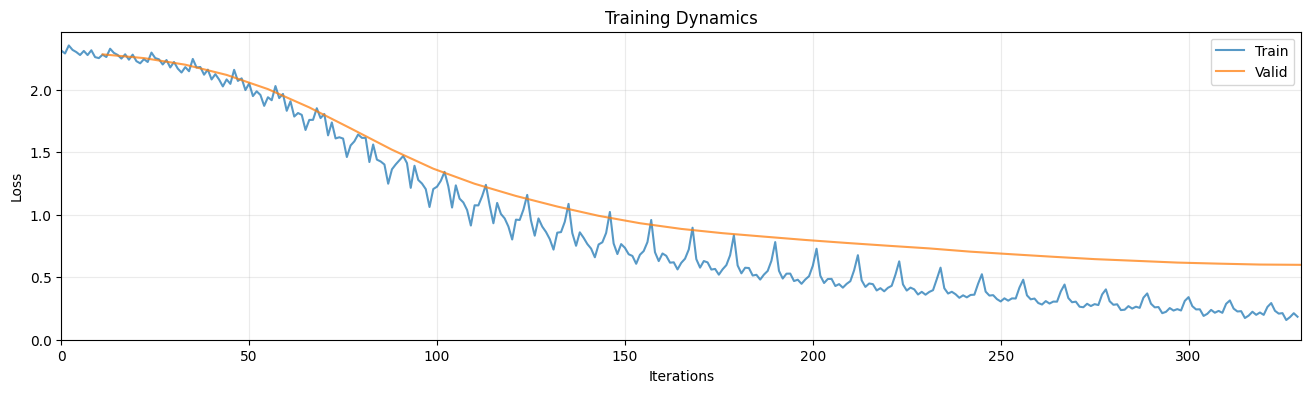

In [128]:
""" Lets plot the training dynamics
"""
# Plot losses from training
def plot_training_performance(train_losses, valid_losses):
  fig = plt.figure(figsize=(16,4))
  ax = fig.add_subplot(111)
  ax.plot(train_losses, linestyle="-", color="tab:blue", label="Train", alpha=0.75)
  ax.plot(valid_losses.keys(), valid_losses.values(), linestyle="-", color="tab:orange", label="Valid", alpha=0.75)
  ax.set_xlim(left=0, right=len(train_losses))
  ax.set_ylim(bottom=0)
  ax.set_xlabel("Iterations")
  ax.set_ylabel("Loss")
  ax.set_title("Training Dynamics")
  ax.legend(loc="best")
  ax.grid(True, alpha=0.25)
  

# Plot 
plot_training_performance(train_losses, valid_losses)

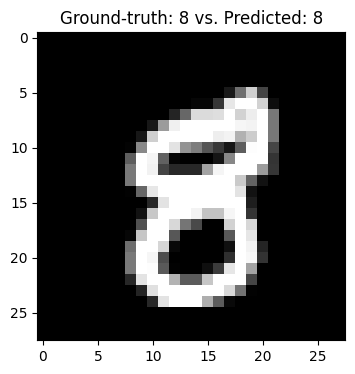

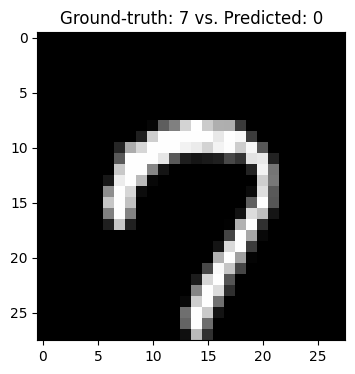

In [129]:
# Investigate the model performance
def plot_prediction(img: Tensor, lbl: int, lbl_p: int) -> Tuple[Any, Any]:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Ground-truth: {lbl} vs. Predicted: {lbl_p}")


# Plot predicted
num_plot = 2 # TODO: Explore different samples by re-running this cell
indexes = random.sample(list(range(len(test_images))), num_plot)
for index in indexes:
    plot_prediction(test_images[index], test_labels[index], test_labels_p[index])

In [130]:
""" Compute the accuracy of our model.
""" 
n_correct = torch.where(test_labels == test_labels_p)[0].shape[0]
n_total = test_labels.shape[0]
print(f"{100*n_correct/n_total:.2f}%")

84.00%


### Examining our Model

Depending on how we design our model we can generally perform digit classification reasonably well. Let's look into our model at the different weights and biases to try and see what it's learned and how it's performing the digit classification.

In [131]:
# Print out the network parameters
for name, param in model.named_parameters():
    print(name, param)

layers.0.fc.weight Parameter containing:
tensor([[ 0.0105,  0.0111,  0.0118,  ..., -0.0109, -0.0327, -0.0288],
        [-0.0285,  0.0028,  0.0064,  ..., -0.0082,  0.0247, -0.0307],
        [-0.0144, -0.0120, -0.0099,  ...,  0.0260, -0.0267, -0.0018],
        ...,
        [-0.0198,  0.0031, -0.0279,  ...,  0.0192, -0.0233, -0.0214],
        [-0.0249, -0.0031, -0.0075,  ..., -0.0297,  0.0069, -0.0167],
        [ 0.0260, -0.0349, -0.0191,  ..., -0.0109, -0.0226, -0.0109]],
       device='cuda:0', requires_grad=True)
layers.0.fc.bias Parameter containing:
tensor([ 0.0876,  0.1574,  0.1548,  0.0811, -0.0045,  0.1597,  0.0866,  0.0638,
         0.1610,  0.0913,  0.0602,  0.1740,  0.1675,  0.1359, -0.0838,  0.1082],
       device='cuda:0', requires_grad=True)
layers.1.fc.weight Parameter containing:
tensor([[ 0.1370, -0.0418,  0.3754,  0.2548,  0.0287,  0.4692,  0.3449,  0.1914,
         -0.1428,  0.2291,  0.0201,  0.0456, -0.1002,  0.4382, -0.0679, -0.1160],
        [ 0.3324,  0.3936,  0.004

Text(0.5, 0, 'Inputs [Input Dimension]')

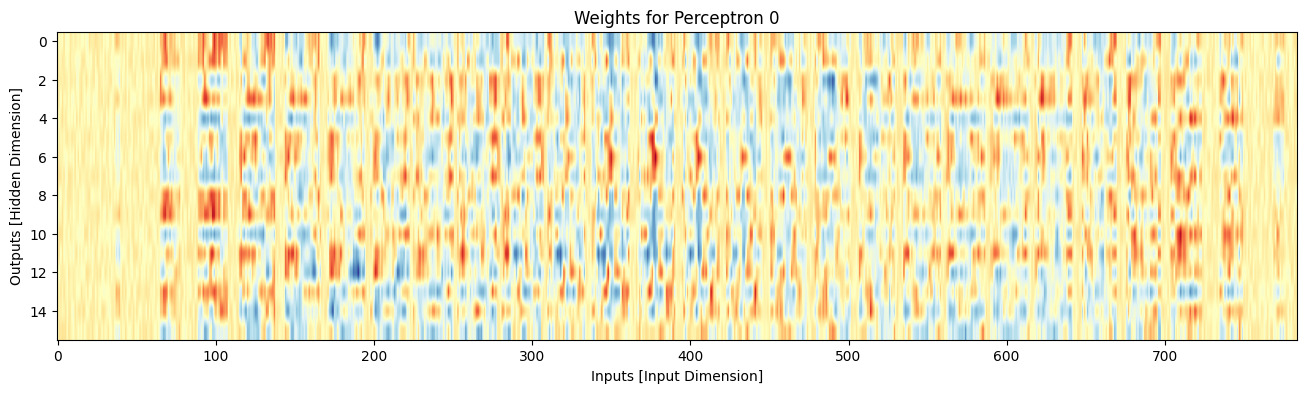

In [132]:
fig, ax = plt.subplots(figsize=(16,4))
ax.imshow(torch.clone(model.layers[0].fc.weight).detach().cpu().numpy(), cmap="RdYlBu", aspect="auto")
ax.set_title("Weights for Perceptron 0")
ax.set_ylabel("Outputs [Hidden Dimension]")
ax.set_xlabel("Inputs [Input Dimension]")

Text(0.5, 1.0, '[Perceptron 8] Weights in Image Space')

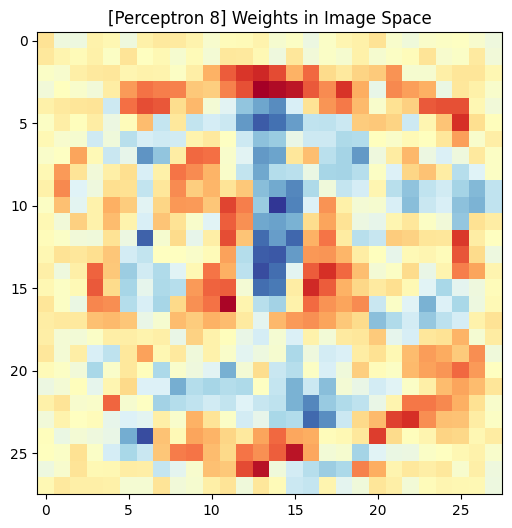

In [133]:
# Model Weights
perceptron_num = 8 # TODO: Channel 0 corresponds to perceptron 0
weights = torch.clone(model.layers[0].fc.weight).detach().cpu()[perceptron_num].reshape(28,28)

# Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(weights, cmap="RdYlBu", aspect="auto")
ax.set_title(f"[Perceptron {perceptron_num}] Weights in Image Space")

We can see that just looking at the raw weights and biases is generally not the most interpretable thing in the world - one of the issues with deep learning. However, we can evaluate the model on some examples and look at the activations and try to build up some intuition around how the network is learning to map these 784 inputs to the 10 output classes.

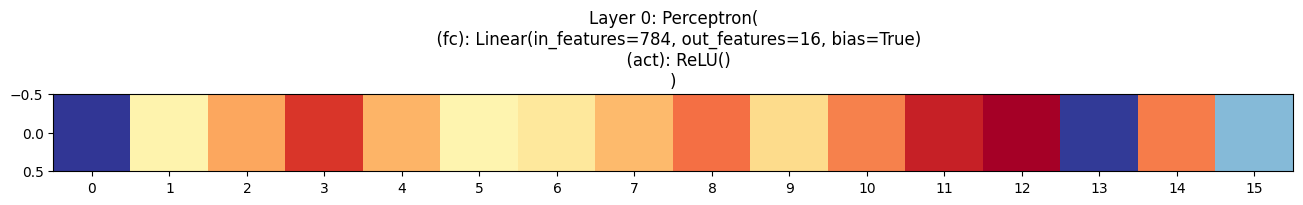

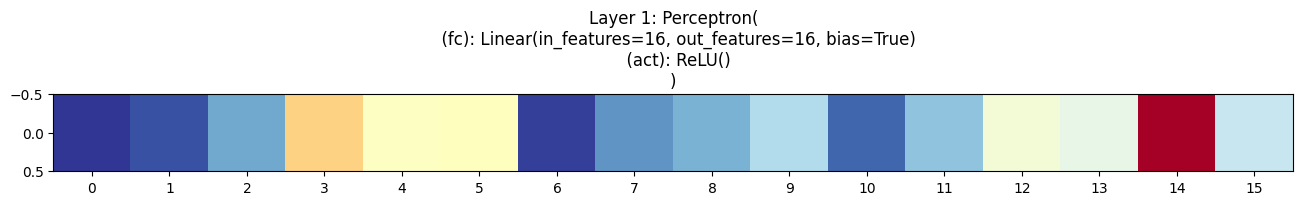

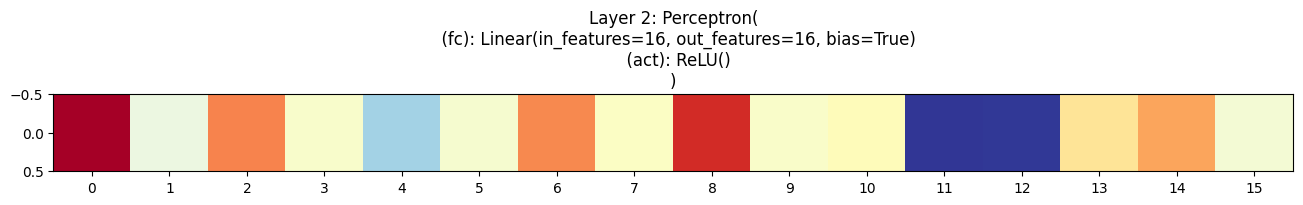

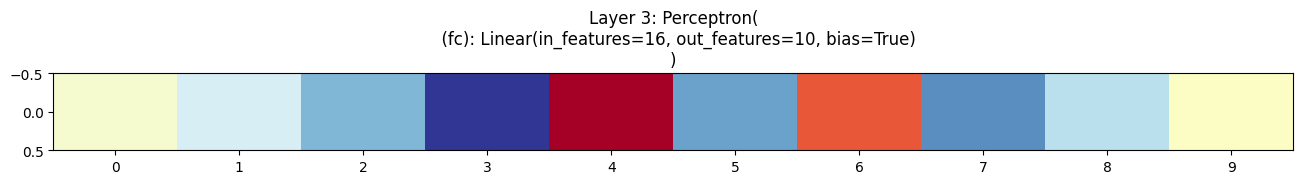

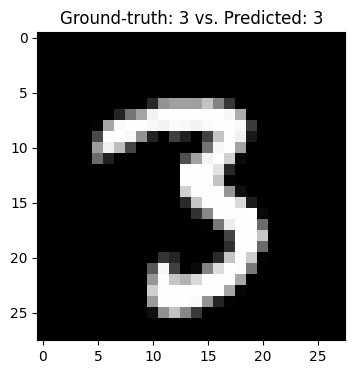

In [134]:
""" Look at the network activations on some dataset examples
"""
# Plot the module activations
def create_hook_function(name: str):
    def plot_module_activations(module, inp, out):
        out = out.detach().cpu().unsqueeze(0)
        fig, ax = plt.subplots(figsize=(16,1))
        ax.imshow(out, cmap="RdYlBu", aspect="auto")
        ax.set_xticks(np.arange(out.shape[-1]))
        # ax.grid(True, alpha=0.25)
        ax.set_title(f"{name}")
    return plot_module_activations


# Attach plotting function to module
for idx, layer in enumerate(model.layers):
    if hasattr(layer, "_forward_hooks"):
        layer.fc._forward_hooks.clear()
    layer.fc.register_forward_hook(create_hook_function(f"Layer {idx}: {layer}"))


# Perform forwards pass and plot results
index = 0 # TODO: See if you can find a pattern in the activations.
img, lbl = test_dataset[index]
img = img.to(device)
img, lbl, lbl_p = model.predict(img, lbl)
plot_prediction(img.cpu(), lbl, lbl_p)


# Clear up the hooks
for idx, layer in enumerate(model.layers):
    if hasattr(layer, "_forward_hooks"):
        layer.fc._forward_hooks.clear()

### Breaking our Model

We have created a MLP model that is capable of fitting the dataset we have trained it on. Similarly to the spiral dataset, when we evaluate the model within the distribution seen during training we can generally expect similar performance. However, we can explore whether the model has managed to generalize the rules necessary for classifying digits.

Let's explore what happens when we translate the image slightly to the left or the right, given the model was never trained on digits in this position - let's see what happens.

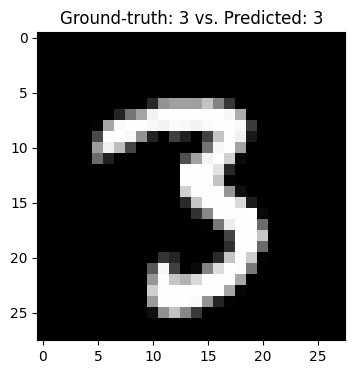

In [141]:
""" Apply different translations to the image.
"""
# Load image from dataset
img, lbl = test_dataset[0] # TODO: Explore different samples

# Transform the image using an affine transform
img = img.reshape(28,28).unsqueeze(0)
img = torchvision.transforms.functional.affine(img, angle=0.0, translate=[0, 0], scale=1.0, shear=0.0) # TODO: Explore different affine transforms
img = img[0].reshape(28*28)

# Pass image to model for prediction
img = img.to(device)
img, lbl, lbl_p = model.predict(img, lbl)
img = img.cpu()
plot_prediction(img, lbl, lbl_p)

We can also explore what happens if we apply different transformations to the image such as rotation or scaling. As before, our model has not seen these sorts of arangements of pixels - let's see what happens.

In [170]:
# TODO: In the cell above try some different rotations, translations, scaling, and shearing

### Discussion

We can see that the performance on these arangements of pixels significantly degrades the performance of the network, it's clear that our model has not learned to generalize the features required for recognizing digits. 

Multi-layer perceptrons operate flattened inputs, as a result it operates on the entire image at once, it doesn't have an awareness of the spatial structure of the image. In this sense it's dependent on the absolute position of the pixels, if we rotate the image it changes the flattened input completely.

Whilst it work, it does not inherently provide many nice properties such as translation invariance, and is generally quite parameter dense.

### **Extra Example 1**

However, an interesting tidbit from this is that we can randomly permute the inputs so the image looks completely garbled when we visualize it. However, the MLP is still able to learn the relationship between the different pixels.

In [142]:
# Randomly index the pixel positions
...

# Visualize the image
...

# Train a model
...

# Evaluate the performance
...

### **Extra Example 2**
During out previous workshop we discuss the balance between the dataset complexity and the model performance. We can take another look at our testing results and break the performance metrics down per digit - we can see the model performs differently on these different classes. We can relate this to the internal balance between intra-class and inter-class complexity, as the model has a fixed capacity each class is competing for resources, some classes require less complex functions to learn to represent than others, as a result the model performs differently on the different classes.

(plot a 1 vs. a 4 )

In [143]:
# Examine the testing performance per class
...

## [Section 2] Detecting Edges by Convolving Filters

Let's think about how we try to classify these numbers, why would you define this digit as a 5?

<img src="MNIST_5.png" alt="5" height="300"/>

How about a 7?

<img src="MNIST_7.png" alt="7" height="300"/>

When we classify digits we tend to be looking for different spatial features such as lines and curves in a spatially equivariant manner (e.g. a line is a line no matter where it is in the image), we're then combining these lower order features into more contextual and discriminative feature space. Let's think about how we can do this...

### Filters

We want some sort of process we can apply to images which will allow us to extract spatial features such as lines and curves in a spatially equivariant manner.

We will first take a look a long employed techniques in image process and computer vision called filters - these filters are manually designed matrices we can convolve over images to achieve results such as sharpening, image blurring or edge detection.

<img src="GaussianKernel.png" alt="Gaussian" height="300"/>

<img src="GaussianBlurred.png" alt="Blur" height="300"/>

We've seen how these work during the lectures, we convolve these matices (or more commonly referred to as kernels) over the image. For a given point they comput the weighted sums of the pixels within the region defined by the kernel.

<img src="Convolution.gif" alt="Convolution" height="300"/>

### Creating and Convolving Filters

We can play around with these kernels ourselve to gain some intuition as to how they work.

We'll begin by defining a 3x3 filter which defines weights for different positions of the kernel, you can make a direct comparison from these kernel to appling an MLP over a smaller region of the image. Where our kernel (or MLP) is now just learning much smaller and simpler features.

<img src="KernelExamples.png" alt="Kernels" height="300"/>

We will take a kernel and apply it to each position in the input image, effectively sliding or convolving, the kernel over the input image. We can see here by sliding these kernels over the image we obtain a strong positive activations for left edges and strong negative activations for right edges. Importantly by applying the same filter everywhere in the image we can extract edges no matter where they are in the image, our result is translation equivariant.

Let's explore some different filter designs and see what sort of spatial features we can extract...

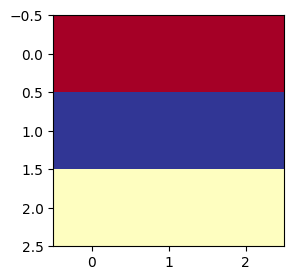

In [144]:
# Define a lower horitonztal edge filter
our_filter_weights = torch.tensor([
    [-1.0, -1.0, -1.0],
    [1.0, 1.0, 1.0],
    [0.0, 0.0, 0.0]
    ], dtype=torch.float32
)

# Define a right vertical edge filter
# our_filter_weights = torch.tensor([ # TODO: Uncomment this if you want to try the vertical edge filter
#     [-1.0, 1.0, 0.0],
#     [-1.0, 1.0, 0.0],
#     [-1.0, 1.0, 0.0]
#     ], dtype=torch.float32
# )

# Let's plot visualize the filter
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(our_filter_weights, cmap="RdYlBu")

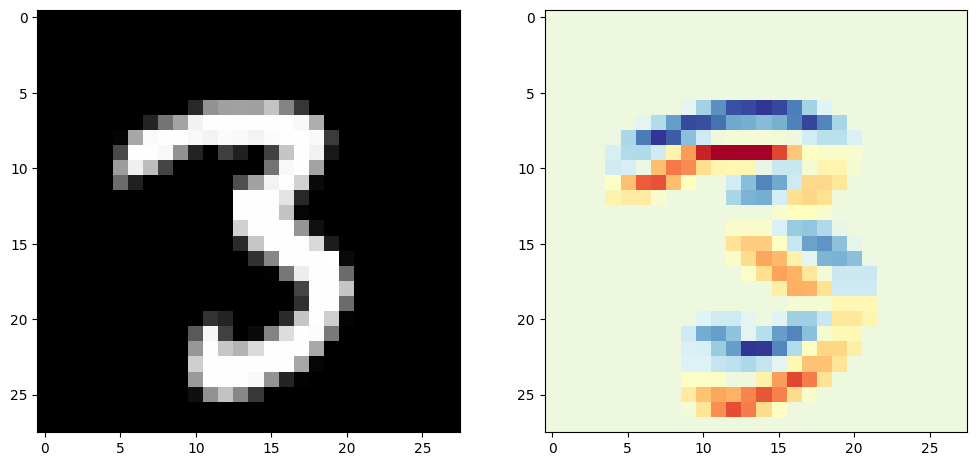

In [145]:
# Let's package it up in a `Conv2d` module for simplcity
conv_filter = nn.Conv2d(1, 1, kernel_size=(3,3), padding=1, bias=False)
conv_filter.weight = nn.Parameter(our_filter_weights.unsqueeze(0).unsqueeze(0))


# Convolve the filter over an image
img, lbl = test_dataset[0] # TODO: Try out different numbers
img = img.reshape(28,28)
filtered_img = conv_filter(img.unsqueeze(0)).detach().squeeze(0).squeeze(0)


# Visualize the filtered image
fig, ax = plt.subplots(figsize=(12,6), ncols=2)
ax[0].imshow(img.squeeze(0), cmap="gray")
ax[1].imshow(filtered_img, cmap="RdYlBu")

### Building up Abstraction: Building a Multi-layer CNN

Similarly to our previous workshop, using a single kernel does not allow us to do much. However, the power comes when we start to use multiple of the kernels in a layer to extract numerous spatial features at once. Furthermore, we can stack layers of these kernels to extract more complex and abstract spatial features.

As we increase kernels in our first layer we allow our model to learn to extract more varied sets of edges from the input image. As we begin to add additional layers of filters allow our model to learn non-linear combinations of the previous filters, allowing us to extract higher-order and increasingly abstract features such as lines, curves, shapes and textures. This ultimately allows us to recognize specific spatial patterns which allow us to perform image classification.

Hand-crafting these filters rapidly becomes an arduous task, especially if we consider adding multiple layers of filters, the sorts of filters and features we want to extract become extremely nebulous. Thankfully, we can use back-propagation and gradient descent based optimization to learn these filters in our network automatically.

### Building a CNN

We will first define a single convolutional layer `ConvLayer`, this layer has `out_channels` kernels associated with it - allowing it to learn `out_channels` sets of filters. An important part of this layer is the `MaxPool2d` which performs pooling in a 3x3 kernel which reduces the dimension of the extracted features (compressing information) and helps provide local translation invariance.

We can then define a model `MultiLayerConv` which stacks multiple of these layers, this allows us to extract progressively more abstract spatial features. We use a `MultiLayerPerceptron` as the final layer of our network to learn the mapping from our extracted spatial features to our 10-dimensional output, each of which represent the probability of the image being classified as a given digit.

Let's see how it performs...

In [275]:
""" Lets define a single Conv layer
"""
class ConvLayer(nn.Module):
    """ Create a single-layer convolution module with ReLU activation function.
    """
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvLayer, self).__init__()

        # Convolution layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1, bias=True)

        # Non-linear ReLU activation
        self.act = nn.ReLU()

        # Max pooling to reduce dimensionality
        self.pooling = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=0)

    def forward(self, x):
        x = self.act(self.conv(x)) if self.act is not None else self.conv(x)
        x = self.pooling(x)
        return x

In [353]:
""" Let's define a model using multiple Conv layers
"""
class MultiLayerConv(nn.Module):
    """ Create a multi-layer convolutional network by stacking multiple convolution.
    """
    def __init__(self, hidden_layers: int, hidden_dim: int):
        super(MultiLayerConv, self).__init__()
        
        # Create an input layer
        modules = [ConvLayer(1, hidden_dim)] # input layer

        # Create some hidden layers
        for _ in range(hidden_layers):
            modules.append(ConvLayer(hidden_dim, hidden_dim)) # hidden layer/s

        # Add these to the model
        self.layers = nn.ModuleList(modules)

        # Create a fully connected output layer
        self.fc = Perceptron(hidden_dim*(2**2), 10, use_activation=False)


    def forward(self, x):
        # extract spatial features using conv layers
        for layer in self.layers:
            x = layer(x)
            
        # flatten & predict logits
        B, C, H, W = x.shape
        x = x.view(B, C*H*W)
        x = self.fc(x)

        return x

    def predict(self, x, lbl):
        lbl = torch.argmax(lbl)
        lbl_p = torch.argmax(self.forward(x))
        return x, lbl, lbl_p

In [354]:
""" Lets print out what we've created
"""
# Model Parameters
hidden_layers = 2
hidden_dim = 16

# Create simple CNN
model = MultiLayerConv(hidden_layers, hidden_dim)

# Display the model
print(model)
print(f"Our model has {sum([np.prod(p.shape) for p in model.parameters() if p.requires_grad])} learnable parameters.")

MultiLayerConv(
  (layers): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
      (pooling): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (1-2): 2 x ConvLayer(
      (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU()
      (pooling): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Perceptron(
    (fc): Linear(in_features=64, out_features=10, bias=True)
  )
)
Our model has 5450 learnable parameters.


An important thing to note here is how much less parameters our model has than our original densely connected network, convolution networks exploit weight sharing by applying the same kernel across the entire image - drastically reducing the number of parameters.

[VALID] Epoch: 30/30 | train loss: 0.198 | valid loss: 0.322: 100%|██████████| 30/30 [00:08<00:00,  3.39it/s]


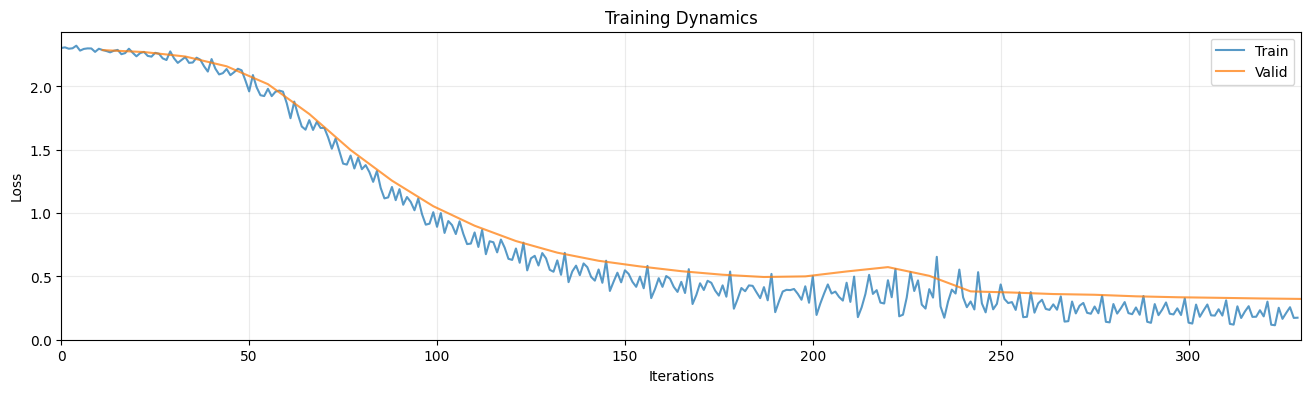

In [378]:
# Setup training items
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = MultiLayerConv(hidden_layers, hidden_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create the dataset
dataset = OurMNIST(mnist, num_samples=1000, flatten=False)

# Split up the dataset into training and testing 
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])

# Create dataloaders to create batches from the datasets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=g)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False, generator=g)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, generator=g)

# Perform training and testing
model, train_losses, valid_losses, test_images, test_labels, test_labels_p = train_model(
    model, 
    train_dataloader, 
    valid_dataloader, 
    test_dataloader, 
    loss_fn, 
    opt, 
    device, 
    30 # TODO: Feel free to change the number of epochs you want to train the model for
)

# Plot 
plot_training_performance(train_losses, valid_losses)

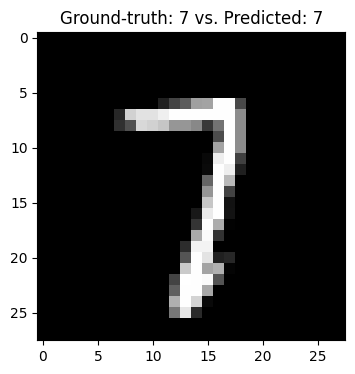

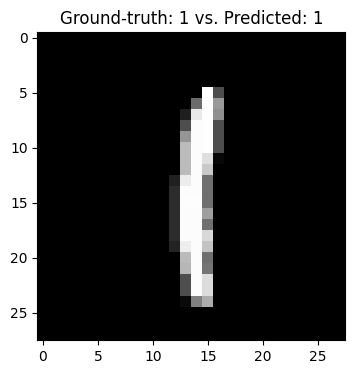

In [379]:
# Plot predicted
num_plot = 2 # TODO: Explore different samples by re-running this cell
indexes = random.sample(list(range(len(test_images))), num_plot)
for index in indexes:
    plot_prediction(test_images[index].squeeze(0,1), test_labels[index], test_labels_p[index])

In [380]:
""" Compute the accuracy of our model.
""" 
n_correct = torch.where(test_labels == test_labels_p)[0].shape[0]
n_total = test_labels.shape[0]
print(f"{100*n_correct/n_total:.2f}%")

91.00%


### Filter & Feature Visualization

We can look at some of the different filters the model has learned during training see if our intuition has any merit. 

As we get deeper into the network looking at the filters themselves.becomes less helpful as they depend on all of the previous filters, as a result we can instead look at features to see what areas in the input image activate this filter to better understand what it represents. We do this by observing the output activations from these different features to see how the network is progressively extracting increasingly abstract spatial features from the input image.

*What do you expect to see?*

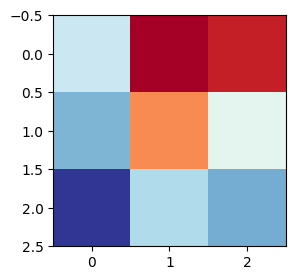

In [381]:
""" Let's explore some of the early-scale kernels
"""
# Extract and display early-scale kernel
kernel_index = 1 # TODO: Try some numbers from 1 to hidden_dim
kernel = torch.clone(model.layers[0].conv.weight[kernel_index,0]).cpu().detach()
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(kernel, cmap="RdYlBu", aspect="auto")

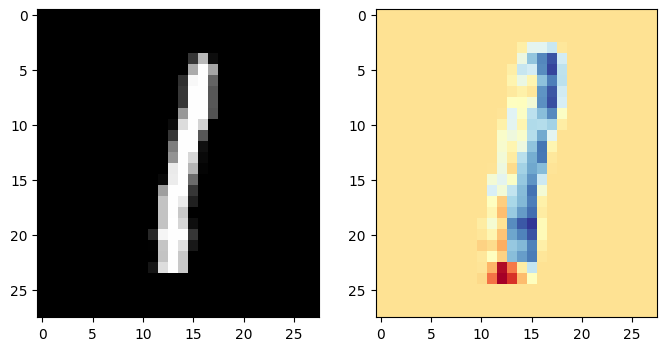

In [382]:
""" Let's see what features are extracted from an image using this kernel
"""
# Let's package it up in a `Conv2d` module for simplcity
conv_filter = nn.Conv2d(1, 1, kernel_size=(3,3), padding=1, bias=False)
conv_filter.weight = nn.Parameter(kernel.unsqueeze(0).unsqueeze(0))

# Convolve the filter over an image
img, lbl = test_dataset[0] # TODO: Try out different numbers
filtered_img = conv_filter(img.unsqueeze(0)).detach().squeeze(0).squeeze(0)

# Visualize the filtered image
fig, ax = plt.subplots(figsize=(8,4), ncols=2)
ax[0].imshow(img.squeeze(0), cmap="gray", aspect="auto")
ax[1].imshow(filtered_img, cmap="RdYlBu", aspect="auto")

We can explore looking at some deeper features, however their meaning becomes less clear as the features generally become more abstract... To extract more useful insights and visualization we generally lend on other interpretability tooling.

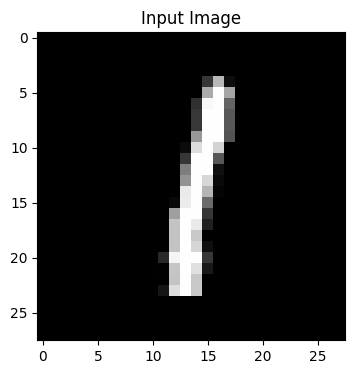

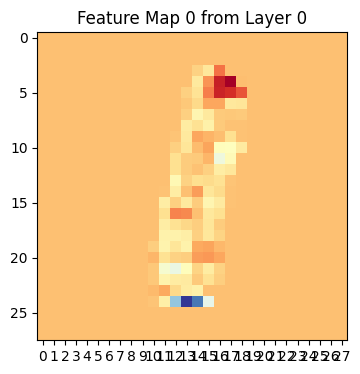

In [406]:
""" Let's look at some of the features extracted by deeper kernels
"""
# Plot the module activations
def create_hook_function(name: str, index: int):
    def plot_module_activations(module, inp, out):
        out = out.detach().cpu()
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(out[0,index], cmap="RdYlBu", aspect="auto")
        ax.set_xticks(np.arange(out.shape[-1]))
        ax.set_title(name)
    return plot_module_activations


# Attach plotting function to module
layer_index = 0
kernel_index = 0
module = model.layers[layer_index].conv
if hasattr(module, "_forward_hooks"):
    module._forward_hooks.clear()
module.register_forward_hook(create_hook_function(f"Feature Map {kernel_index} from Layer {layer_index}", kernel_index))


# Perform forwards pass and plot results
img, lbl = test_dataset[0] # TODO: Try out some different samples
img = img.to(device).unsqueeze(0)
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(img.cpu().squeeze(0,1), cmap="gray")
ax.set_title(f"Input Image")
_ = model(img)


# Clear up the hooks
for idx, layer in enumerate(model.layers):
    module = layer.conv
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()

If you're interested in feature visualization or more general interpretability tools for deep-learning models there is an excellent article on [DistillPub - Feature Visualization](https://distill.pub/2017/feature-visualization/) and [Captum](https://github.com/pytorch/captum) has some excellent tools.

### Breaking our Model

Our previous MLP model was extremely sensitive the translation, our new CNN model should be able to better handle translations within the image plane. However, due to the multi-layer perceptron and the maximum pooling, our model will not truly be translation invariant.

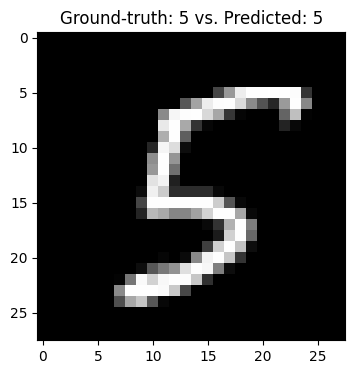

In [306]:
""" Apply different translations to the image...
"""
# Load image from dataset
img, lbl = test_dataset[0] # TODO: Explore different samples

# Transform the image using an affine transform
img = torchvision.transforms.functional.affine(img, angle=0.0, translate=[0, 0], scale=1.0, shear=0.0) # TODO: Explore different translations

# Pass image to model for prediction
img = img.unsqueeze(0).to(device)
img, lbl, lbl_p = model.predict(img, lbl)
img = img.cpu().squeeze(0,1)
plot_prediction(img, lbl, lbl_p)

Our model seems to have improved robustness to the pertubations in positions. However more interestingly is that we've managed to achieve this alongside a performance improvement whilst using significantly less parameters than our previous MLP model.

Being able to design neural networks which exploit the underlying symmetries of your problem, in the case the natural spatial structure of our image, is a very fundamental and powerful design philosophy in deep learning.

Out of curiousity let's see how our model reacts to rotations and scaling of the image...

*What do you expect?*

In [408]:
""" Rotate the image...
"""
# TODO: In the previous cell try rotating the image

' Rotate the image...\n'

In [409]:
""" Scale the image...
"""
# TODO: In the previous cell try rotating the image

' Scale the image...\n'

Okay, so our model seems to struggle with rotation and scaling, lets have a think about why this occurs.

*How can we go about solving this?*

Our model architecture is perfectly capable of learning rotated or even upside down digits through the kernels, these would just represent a different distribution of spatial features and thus filters for our model to learn. 

During our previous workshop we showed that if we made the dataset more complex we had to increase the complexity of the model to match this, the same idea also applies here. Lets say we want to train our model on straight AND rotated images, then our network is going to have to (potentially) allocate some additional capacity to learn these other filters for different angles and orientations, and combinations of these edges that it didn't have to before - it has more to learn. 

We could also alter our model architecture such by incorporating rotation invariance into the architecture itself, but it turns out to be much more computationally efficient and practical to simply increase the scale of our model as use these same building blocks, whilst simply augmenting the training distribution.

In [414]:
""" Create a dataset with augmentations
"""
class AugmentedOurMNIST(torch.utils.data.Dataset):
    def __init__(self, mnist: MNIST, num_samples: Optional[int] = None, flatten: Optional[bool] = True):
        super(AugmentedOurMNIST, self).__init__()
        self.mnist = mnist
        self.num_samples = num_samples if num_samples is not None else len(self.mnist)
        self.index = list(range(self.num_samples))
        assert len(self.index) < len(self.mnist), f"Tried to use {num_samples} but MNIST only has {len(self.minst)}"
        self.flatten = flatten

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, index: int) -> Tuple[Tensor, Tensor]:
        img, lbl = self.mnist[index] # load from mnist

        # image prep
        img = torch.from_numpy(np.asarray(img).copy()) # copy into tensor
        if self.flatten: 
            img = img.reshape(28*28) # flatten from 28x28 to 784
        else:
            img = img.unsqueeze(0) # using img shape as [1,28,28]
            
        # TODO: You can apply these transforms randomly to "augment" the training distribution
        prob_of_applying = random.random()
        if prob_of_applying > 0:
            img = torchvision.transforms.functional.affine(img, angle=180.0, translate=[0, 0], scale=1.0, shear=0.0)

        img = img.to(dtype=torch.float32) # cast to fp32
        img = img / 255 # scale to 0-1

        # label prep
        lbls = torch.zeros((10), dtype=torch.float32) # create one-hot encoding of vector
        lbls[lbl] = 1.0 # set label index

        return img, lbls

[VALID] Epoch: 30/30 | train loss: 0.134 | valid loss: 0.284: 100%|██████████| 30/30 [00:13<00:00,  2.16it/s]


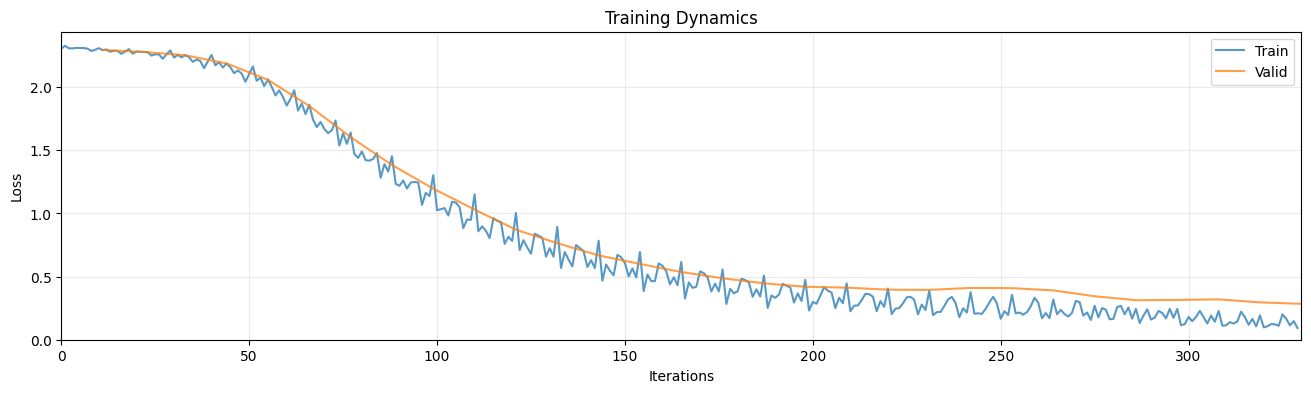

In [415]:
# Setup training items
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = MultiLayerConv(hidden_layers, hidden_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create the dataset
dataset = AugmentedOurMNIST(mnist, num_samples=1000, flatten=False)

# Split up the dataset into training and testing 
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1])

# Create dataloaders to create batches from the datasets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, generator=g)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False, generator=g)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, generator=g)

# Perform training and testing
model, train_losses, valid_losses, test_images, test_labels, test_labels_p = train_model(
    model, 
    train_dataloader, 
    valid_dataloader, 
    test_dataloader, 
    loss_fn, 
    opt, 
    device, 
    30
)

# Plot 
plot_training_performance(train_losses, valid_losses)

Note: if you apply it randomly you may need to increase the training time or model to suit.

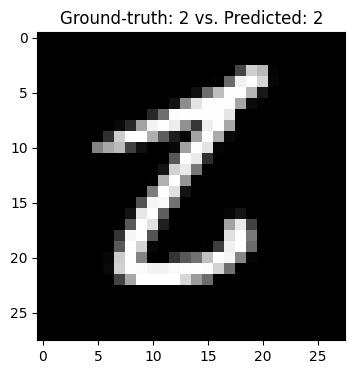

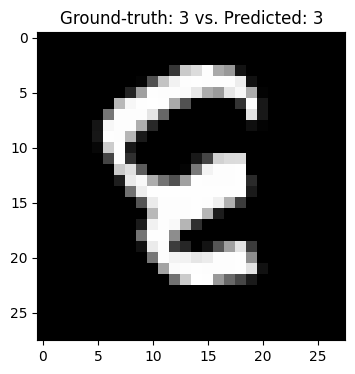

In [419]:
# Plot predicted
num_plot = 2
indexes = random.sample(list(range(len(test_images))), num_plot)
for index in indexes:
    plot_prediction(test_images[index].squeeze(0,1), test_labels[index], test_labels_p[index])

## [Section 3] Pre-trained Models

Whilst we can train these models ourselves, sometimes it's extremely useful to be able to piggyback off a pre-existing solution. In these scenarios pre-trained models are extremely useful, rather than having to go through the R&D of designing a model, collecting enough data, and figuring our how to train a model - we can use a model someone has already trained.

However there are some important caveats with this.

### What are pre-trained models?

Pre-trained models involve a model that someone has trained on a dataset to perform a specific task such as object detection, image classification, 3D landmark detection, image generation, etc. We can use these pre-trained models to perform different tasks.

The following links contain some good resources.
- https://pytorch.org/vision/stable/models.html (computer vision models)
- https://huggingface.co/blog/cv_state (much more complex models and pre-built pipelines)

In [428]:
!pip install 'transformers[torch]'

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


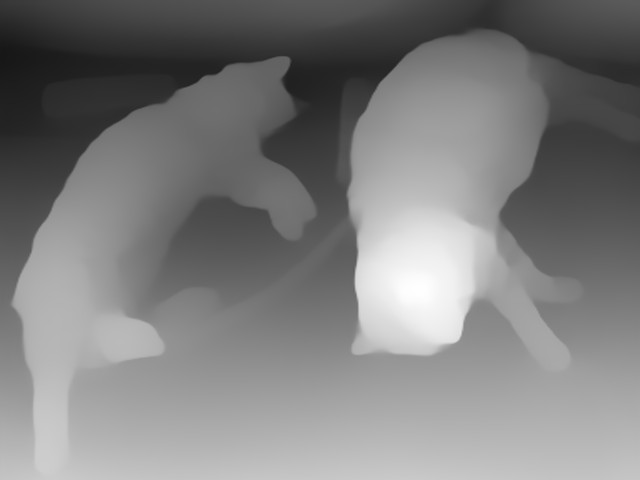

In [429]:
from transformers import pipeline

depth_estimator = pipeline(task="depth-estimation", model="Intel/dpt-large")
output = depth_estimator("http://images.cocodataset.org/val2017/000000039769.jpg")

# This is a tensor with the values being the depth expressed
# in meters for each pixel
output["depth"]

### When to use pre-trained models?

Similarly to how our model trained on digits really only knows how to classify digits, we need to be aware of what the different pre-trained models are pre-trained to do. E.g. there's not point using a model for image classification if you want to perform object detection out-of-the-box.

Furthermore, as we saw our CNN was reasonable on in-distribution samples, however when we rotated the image slightly it fell over. When using pre-trained models we have to be aware of the training distribution to understand in what situations we can expect reasonable performance.

However, most of the time they can just be extremely fun to play around with.

In [424]:
!pip install diffusers["torch"] transformers

     |████████████████████████████████| 2.2 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.1 MB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 776 kB 55.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 52.3 MB/s eta 0:00:01
     |████████████████████████████████| 401 kB 39.4 MB/s eta 0:00:01
     |████████████████████████████████| 302 kB 40.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 46.5 MB/s eta 0:00:01


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 12.36it/s]


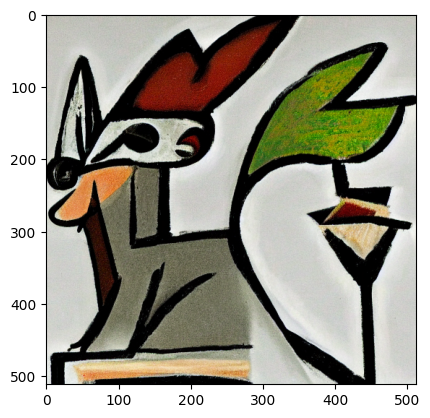

In [439]:
from diffusers import DiffusionPipeline

generator = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
generator.to("cuda:0")

image = generator("An image of a squirrel in Picasso style").images[0]

plt.imshow(image)

100%|██████████| 50/50 [00:04<00:00, 12.30it/s]


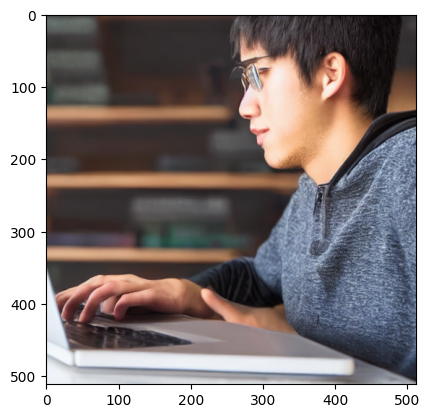

In [451]:
image = generator("Student Studying Machine Learning on a Laptop").images[0]
plt.imshow(image)

### Fine-tuning pre-trained models?

Across various computer vision tasks such as object detection or depth estimation, much of what we'd expect the early layers to do in these networks remains the same e.g. learning edges, shapes, and textures. Pre-trained models generally have quite good feature extraction.

Say we have a fairly small scale dataset that we want to train a model on e.g. to detect specific types of objects. We can leverage the pre-trained features in these models to expedite the learning process. We can either re-train a model, you can think of this as starting training but from a much better initialization point than just random weights and biases. 

Sometimes this can involve modify the architecture slightly, such as just the classification head to use a different number of classes, whilst retaining the backbone.

We can also freeze part of our model to avoid modifying the existing components, and just learn the higher order features. 

In [448]:
# https://pytorch.org/vision/stable/models.html
from torchvision.models import resnet50, ResNet50_Weights

# Load the pre-trained model
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Freeze the network parameters
for param in model.parameters():
    param.requires_grad = False

# Overwrite the classification head of the network
your_number_of_classes = 16
model.fc = nn.Linear(2048, your_number_of_classes)

# Run training for just the classification head
...

Ellipsis

### What are foundation models?
Well they're really not different from pre-trained models, however the scale and complexity both of the model and dataset is typically much larger - we hope this results in much more generalized features to the point where fine-tuning is not required for some down-stream task aka. they have strong zero-shot performance. We can use the much more robust and representative features from these models to perform different tasks without as much re-training.

In [449]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-goobr0wg
  Running command git clone -q https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-goobr0wg
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=a6b3cfae9deaaf71e505f92e567040560af7d03c792f216ae2c58a8dd72db963
  Stored in directory: /tmp/pip-ephem-wheel-cache-ughc6hl7/wheels/b0/7e/40/20f0b1e23280cc4a66dc8009c29f42cb4afc1b205bc5814786
Successfully built segment-anything


In [ ]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

In [515]:
!pip install pycocotools
!pip install -q supervision

In [507]:
# https://github.com/facebookresearch/segment-anything?tab=readme-ov-file#model-checkpoints
from segment_anything import SamPredictor, sam_model_registry
from pathlib import Path

# Load model
checkpoint = Path(".").joinpath("sam_vit_b_01ec64.pth")
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=checkpoint).to("cuda:0")

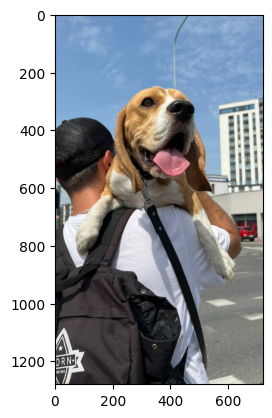

In [534]:
# Use a pre-existing example image
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
import cv2
image_bgr = cv2.imread("dog.jpeg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [552]:
""" Perform some mask generation around an object
""" 
from segment_anything import SamAutomaticMaskGenerator

# Disable deterministic
torch.use_deterministic_algorithms(False)

# Create mask generator
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.95
)

# Run forwards process on image
sam_results = mask_generator.generate(image_rgb)

In [553]:
import supervision as sv
detections = sv.Detections.from_sam(sam_result=sam_results)
print(detections.mask.shape)

(9, 1280, 720)


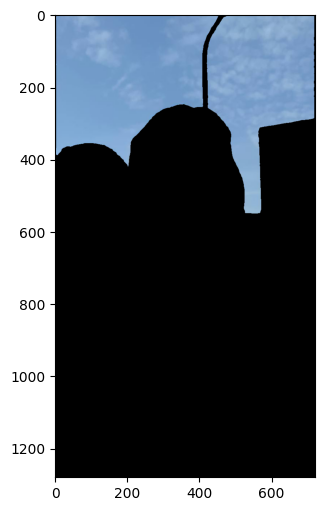

In [556]:
_img = image_rgb.copy()
_img[~detections.mask[0]] = .0
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(_img)

In [557]:
# Check out: https://github.com/RockeyCoss/Prompt-Segment-Anything?tab=readme-ov-file

### **Extra Example**
Lots of different advancements in different applications of computer vision just come from thinking about how these general architectures can be applied in different ways, and finding the data to do so. Rather than just performing object classification - take in 28*28 pixels and output 0-9 numbers.

We could equally use this architecture to detect 2D facial landmarks, where we input say 72*72 pixel image, and output 68*2 numbers representing the position of some points on the face.

We could output 72*72*Nc numbers, re-mapping back to the image where each pixel is associated with a class probability - we call this semantic segmentation.

We could also outptu a number with a 72*72 where pixel has a number associated with it, this is called depth estimation

Lots of different applications of computer vision exist, each of these different problems has a different set of application specific challenges related to it, and will have their own data structures and dataset used for training, but we can use these building blocks and put them together in differents ways e.g. CNNs to do these different tasks.

### **Extra Example**
Different types of architectures generally has these different intuitions built into them, these are called inductive biases, they help the models be much more efficient in their learning because they're biases towards exploiting a symmetry that we've designed. Understanding what the intuition behind these models and how they function is a core aspect of designing machine learning systems - 

But that's not to say you can't use these in the wrong way - you can equally express the image as a sequence of 784 pixels - and while it's not ideal you can equally train an LSTM to predict MNIST images in this manner.

However the LSTM doesn't exploit the structure of images in a very natural way - but say we had some sequential data of someone hand-writing these digits, the understanding the sequence of points might make much more sense.